In [30]:
from pathlib import Path
from loadPressureData import loadPressureData
from loadPressureData import matlab_datenum_to_datetime64
import numpy as np
from BulkWaveStats import wavenumber


import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from scipy.signal import spectrogram
import pandas as pd

# Comparing offshore (S6) to nearshore sensor (S1)

![instrument](figs/array.jpg)


For this, I will be comparing sensor 1 and 6 in an attempt to:

- compute spectra for both
- compute bulk wave statistics
- remove tide (potentially by subtracting S6-S1)
- remove water depth signal 
- compute runup 
- compute changes in water level 
- look at specific storm events/model those events

Notes: 
Sensor 1 is never underwater. checked by this code:
'''python

    import numpy as np

    def long_nan_runs(data, min_len=21):
        data = np.asarray(data, dtype=float)
        isnan = np.isnan(data)
        idx = np.flatnonzero(isnan)
        if idx.size == 0:
            return []
        breaks = np.where(np.diff(idx) > 1)[0]
        starts = np.concatenate(([0], breaks + 1))
        ends = np.concatenate((breaks, [idx.size - 1]))

        long_runs = []
        for s, e in zip(starts, ends):
            run = idx[s:e + 1]
            if run.size >= min_len:
                long_runs.append(run)
            
            return long_runs '''

'''python
    runs = long_nan_runs(depth_m, min_len=21)  # look for anything longer than the 20-s gap
    if runs:
        print(f"Found {len(runs)} long NaN run(s).")
        for run in runs[:5]:
            start, end = run[0], run[-1]
            print(f"  samples {start}–{end} (length {run.size}), around {time[start]} to {time[end]}")
    else:
        print("No NaN runs longer than 20 samples.")'''

#### Compute Water Depth 

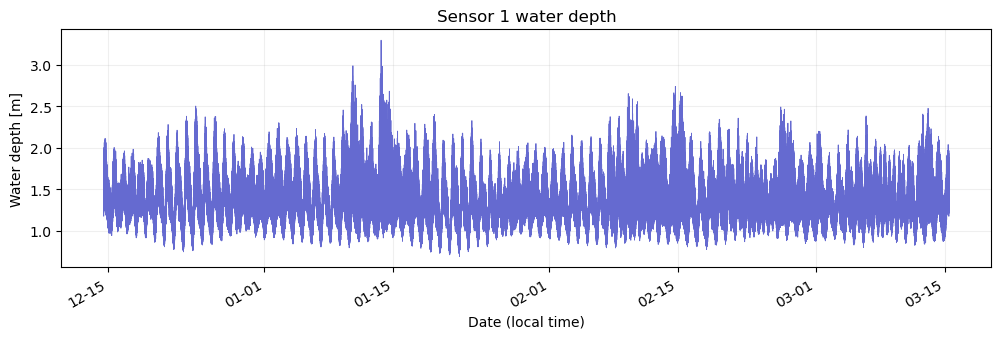

In [3]:
# load / process pressure data 
bursts = loadPressureData(Path("MoA18411.mat"))
t1 = bursts.time           # numpy datetime64[ns]
h1 = bursts.depth_m       # hydrostatic depth in meters
p1 = bursts.pressure_pa

# !!!!!!!!!!!!!additional sensor can be loaded here!!!!!!!!!!!!!!!! #
# !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! #
# !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! #
# !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! #
# !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! #
# !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! #



# plot water depth time series
fig, ax = plt.subplots(figsize=(12, 3.5))
ax.plot(t1, h1, linewidth=0.6, color="#656AD0", label='Sensor 1 Depth (m)')
# ax.plot(t2,h2, linewidth=0.6, color="#D0656A", label = 'Sensor 6 Depth (m)')
ax.set_ylabel('Water depth [m]')
ax.set_xlabel('Date (local time)')
ax.set_title('Sensor 1 water depth')
#ax.legend()
ax.grid(True, alpha=0.2)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
fig.autofmt_xdate()
plt.show()

#### Remove tidal signal

After talking to mark, decided that the best way to do this without removing setup as well is to subtract Sensr 6 from sensor 1. Since tides are constant, it **shouldn't** be difficult to do

#### Autospectra

Text(0.5, 1.0, 'Autpspectra of Sensor 1 with nperseg=8192')

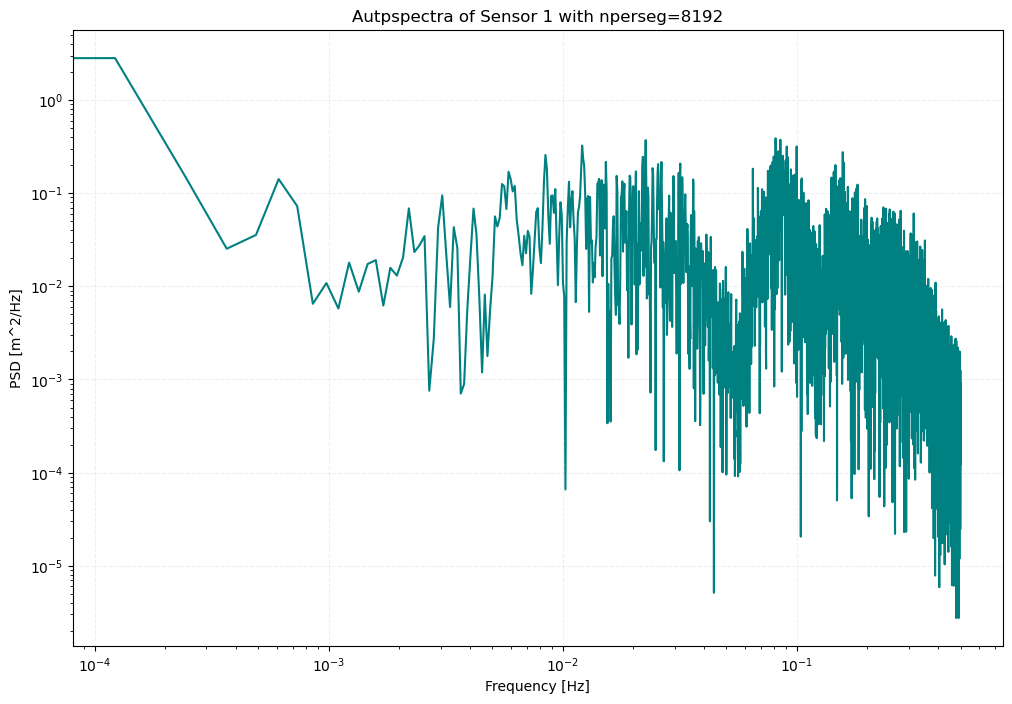

In [4]:
# INPUT VALUES
fs = 1.0 # sample rate in Hz
nperseg = 8192

# convert to pandas Series indexed by datetime and interpolate missing values
h_interp = pd.Series(h1, index=pd.to_datetime(t1)).interpolate(method='linear', limit_direction='both', limit=20).to_numpy()
p_interp = pd.Series(p1, index=pd.to_datetime(t1)).interpolate(method='linear', limit_direction='both', limit=20).to_numpy()

freqs, t_spec, Spp = spectrogram(
    h_interp,
    fs=fs,
    window = 'hann',
    nperseg = nperseg,
    noverlap = nperseg // 4, 
    detrend = 'constant',
    scaling = 'density',
    mode='psd', 
)

plt.figure(figsize=(12, 8))
plt.loglog(freqs, Spp[:,100], color='teal')
plt.grid(True, linestyle='--', alpha=0.2)
plt.xlabel('Frequency [Hz]')
plt.ylabel('PSD [m^2/Hz]')
plt.title('Autpspectra of Sensor 1 with nperseg={}'.format(nperseg))




#### Bulk Wave Statistics

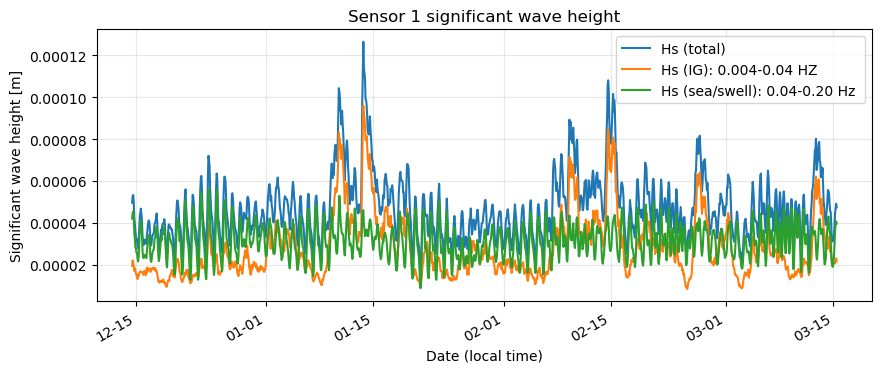

In [26]:
hs_tot, hs_ig, hs_ss = sig_wave_height(Spp, freqs, t_spec, t1, h1)

t0 = pd.to_datetime(t1[0]).to_datetime64()   # start time as datetime64[ns]
t_spec_ns = (t_spec * 1e9).astype("timedelta64[ns]")  # seconds → nanoseconds
t_Sxx = t0 + t_spec_ns  



fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(t_Sxx, hs_tot, label='Hs (total)')
ax.plot(t_Sxx, hs_ig, label='Hs (IG): 0.004-0.04 HZ')
ax.plot(t_Sxx, hs_ss, label='Hs (sea/swell): 0.04-0.20 Hz ')
ax.set_ylabel('Significant wave height [m]')
ax.set_xlabel('Date (local time)')
ax.set_title('Sensor 1 significant wave height')
ax.grid(True, alpha=0.3)
ax.legend(loc='upper right')
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
fig.autofmt_xdate()
plt.show()